# # Data Preprocessing, Averaging over all csv-files and Saving the averaged data into new csv-file

In [23]:
import os
import pandas as pd
import json 
from collections import Counter

directory = '../Daten/firsttry/'

averaged_path = '../Daten/averaged_data.csv'

if os.path.exists(averaged_path):
    os.remove(averaged_path)
    print(f"Removed {averaged_path}")


# Get list of CSV files
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

averaged_data = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(directory + file, sep=';')
    # Drop unnecessary columns like timeStampNetwork and timeStampGPS
    df = df.drop(columns=['timeStampNetwork', 'timeStampGPS', 'bAccuracyNetwork', 'speedAccuracyNetwork', 'cellType'])
    # Remove first x rows and reset begin index to 0
    removedRows = 3
    df = df.iloc[removedRows:]
    df = df.reset_index(drop=True)
    
    # Load satellites json
    df['satellites'] = df['satellites'].apply(lambda x: json.loads(x))
    
    # Add columns of nr of satellite of each constellation
    df['GPS_counts'] = df['satellites'].apply(lambda x: Counter([sat['constellation'] for sat in x if sat['constellation'] == 'GPS']).get('GPS', 0))
    
    df['BEIDOU_counts'] = df['satellites'].apply(lambda x: Counter([sat['constellation'] for sat in x if sat['constellation'] == 'BEIDOU']).get('BEIDOU', 0))
    
    df['GALILEO_counts'] = df['satellites'].apply(lambda x: Counter([sat['constellation'] for sat in x if sat['constellation'] == 'GALILEO']).get('GALILEO', 0))
    
    df['GLONASS_counts'] = df['satellites'].apply(lambda x: Counter([sat['constellation'] for sat in x if sat['constellation'] == 'GLONASS']).get('GLONASS', 0))
    
    # Add cn0 column for easier computation of statistics
    df['satellite_cn0'] = df['satellites'].apply(lambda x: [sat['cn0'] for sat in x])
    
    # Calculate median, mode, variance, standard deviation and range of the satellite cn0
    df['satellite_cn0_median'] = df['satellite_cn0'].apply(lambda x: pd.Series(x).median())
    df['satellite_cn0_mode'] = df['satellite_cn0'].apply(lambda x: pd.Series(x).mode()[0] if not pd.Series(x).mode().empty else None)
    df['satellite_cn0_std'] = df['satellite_cn0'].apply(lambda x: pd.Series(x).std())
    df['satellite_cn0_range'] = df['satellite_cn0'].apply(lambda x: pd.Series(x).max() - pd.Series(x).min())
    
    # load the bluetooth json and load rssi into a new column
    df['bluetoothDevices'] = df['bluetoothDevices'].apply(lambda x: json.loads(x))
    df['bluetooth_rssi'] = df['bluetoothDevices'].apply(lambda x: [device['rssi'] for device in x])
    
     # Calculate statistical figures for the bluetooth devices
    df['bluetooth_rssi_median'] = df['bluetooth_rssi'].apply(lambda x: pd.Series(x).median())
    df['bluetooth_rssi_mode'] = df['bluetooth_rssi'].apply(lambda x: pd.Series(x).mode()[0] if not pd.Series(x).mode().empty else None)
    df['bluetooth_rssi_std'] = df['bluetooth_rssi'].apply(lambda x: pd.Series(x).std())
    df['bluetooth_rssi_range'] = df['bluetooth_rssi'].apply(lambda x: pd.Series(x).max() - pd.Series(x).min())
    
    # load the wifi json and load rssi into a new column
    df['wifiDevices'] = df['wifiDevices'].apply(lambda x: json.loads(x))
    df['wifi_rssi'] = df['wifiDevices'].apply(lambda x: [device['level'] for device in x])
    
     # Calculate statistical figures for the wifi devices
    df['wifi_rssi_median'] = df['wifi_rssi'].apply(lambda x: pd.Series(x).median())
    df['wifi_rssi_mode'] = df['wifi_rssi'].apply(lambda x: pd.Series(x).mode()[0] if not pd.Series(x).mode().empty else None)
    df['wifi_rssi_std'] = df['wifi_rssi'].apply(lambda x: pd.Series(x).std())
    df['wifi_rssi_range'] = df['wifi_rssi'].apply(lambda x: pd.Series(x).max() - pd.Series(x).min())
    
    # Drop list columns
    df.drop(columns=['satellites', 'bluetoothDevices', 'wifiDevices', 'satellite_cn0', 'bluetooth_rssi', 'wifi_rssi'], inplace=True)
    
     # Average over all columns for numeric values and take the first of non-numeric to have a single row
    label = df.iloc[0]['label']
    networkLocationType = df.iloc[0]['networkLocationType']
    
    df.drop(columns=['label', 'networkLocationType'], inplace=True)
    
    df = df.mean().to_frame().T
    
    df['label'] = label
    
    #place label at the beginning
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    
    # One hot encode the networkLocationType 
    df['networkLocationType'] = 0
    if networkLocationType == 'wifi':
        df['networkLocationType'] = 1
    elif networkLocationType == 'cell':
        df['networkLocationType'] = 2
    elif networkLocationType == 'cell+wifi':
        df['networkLocationType'] = 3
    
    # if the nr of satellites is 0, then replace hAccurracyGPS, vAccuracyGPS, speedAccuracyGPS, bAccuracyGPS with NaN
    df.loc[df['nrSatellitesInFix'] == 0, ['hAccuracyGPS', 'vAccuracyGPS', 'speedAccuracyGPS', 'bAccuracyGPS']] = None
    
    averaged_data = pd.concat([averaged_data, df], ignore_index=True)
    
    
averaged_data.sort_values(by=['label'], inplace=True)
averaged_data.to_csv(averaged_path, index=False)
averaged_data

,label,cellStrength,hAccuracyNetwork,vAccuracyNetwork,hAccuracyGPS,vAccuracyGPS,bAccuracyGPS,speedAccuracyGPS,nrSatellitesInView,nrSatellitesInFix,...,satellite_cn0_range,bluetooth_rssi_median,bluetooth_rssi_mode,bluetooth_rssi_std,bluetooth_rssi_range,wifi_rssi_median,wifi_rssi_mode,wifi_rssi_std,wifi_rssi_range,networkLocationType
9,Indoor,1.071429,16.903071,1.235335,1.9,9.9,178.3,0.9,28.571429,25.0,...,NaN,-91.0,-96.0,11.244463,52.0,-67.0,-67.0,7.14065,17.0,1
15,Indoor,4.0,22.296462,8.442781,5.434615,29.484615,146.761538,3.038462,47.0,9.538462,...,12.692308,-80.0,-80.0,18.115287,51.0,-85.076923,-88.0,8.166664,18.384615,1
14,Indoor,2.535714,20.095393,1.995118,None,None,None,None,37.0,0.0,...,NaN,-84.142857,-61.0,13.846676,36.607143,-73.607143,-80.357143,11.132022,25.285714,1
10,Indoor,1.578947,44.897211,8.357078,None,None,None,None,36.0,0.0,...,NaN,-93.052632,-67.157895,26.664825,63.578947,-78.5,-89.105263,11.209734,27.789474,1
6,Indoor,2.965517,14.174379,1.0,None,None,None,None,37.0,0.0,...,NaN,-92.965517,-98.37931,12.799422,51.0,-72.689655,-73.62069,9.1061,25.068966,1
18,Indoor,4.0,17.527208,8.852464,None,None,None,None,37.0,0.0,...,NaN,-84.0625,-86.375,14.482453,50.25,-79.0,-86.0,12.342339,24.0,1
4,Indoor,1.928571,22.792679,1.888168,None,None,None,None,22.857143,0.0,...,NaN,-92.964286,-96.642857,12.117509,51.928571,-84.5,-85.0,0.707107,1.0,1
2,Indoor,3.506667,13.8424,1.041931,None,None,None,None,37.0,0.0,...,NaN,-93.446667,-96.453333,13.357066,37.973333,-72.8,-84.72,9.53513,30.32,1
7,Outdoor,4.0,21.054852,5.57111,1.362963,7.637037,116.288889,0.603704,52.0,30.666667,...,27.451852,-92.462963,-93.0,11.826576,59.333333,-85.5,-91.518519,9.308551,34.740741,1
8,Outdoor,4.0,39.679538,4.643153,1.380769,8.934615,154.761538,0.634615,51.0,30.230769,...,25.676923,-91.442308,-92.923077,16.902139,56.846154,-86.923077,-93.153846,6.873291,20.384615,0


## Visualization

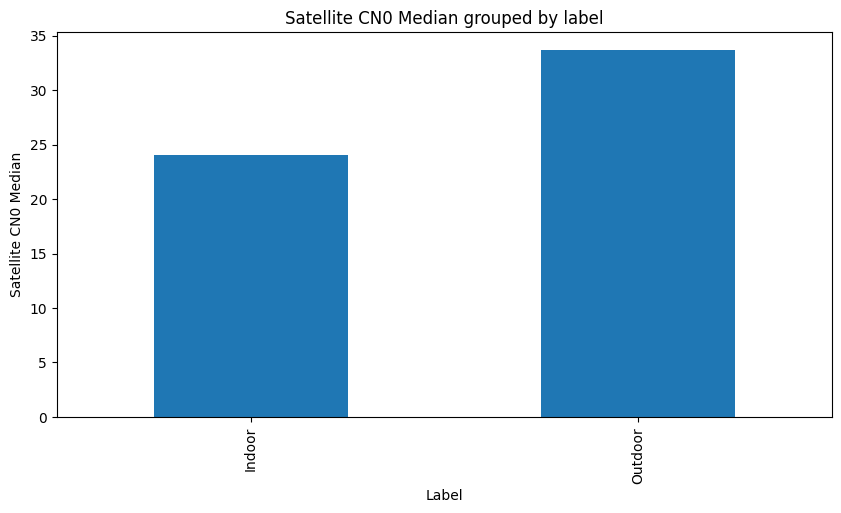

In [24]:

import matplotlib.pyplot as plt

# Plot the distribution of the labels
plt.figure(figsize=(10, 5))
averaged_data['label'].value_counts().plot(kind='bar')
plt.title('Distribution of the labels')
plt.xlabel('Label')
plt.ylabel('Count')
#plt.show()
plt.close()

# Plot the satellite cn0 means and counts, grouped by label
plt.figure(figsize=(10, 5))
averaged_data.groupby('label')['satellite_cn0_median'].mean().plot(kind='bar')
plt.title('Satellite CN0 Median grouped by label')
plt.xlabel('Label')
plt.ylabel('Satellite CN0 Median')
plt.show()



